In [1]:
from model import Transformer
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import logging
import time # debugging
from plot import plot_training_crypto, plot_loss
from helpers import log_loss, clean_directory
from joblib import load
from icecream import ic
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import math, random

In [2]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

In [3]:
def flip_from_probability(p):
    return True if random.random() < p else False

In [4]:
# def transformer(dataloader, EPOCH, k, frequency, path_to_save_model, path_to_save_loss, path_to_save_predictions, device):

#     device = torch.device(device)

#     model = Transformer().double().to(device)
#     optimizer = torch.optim.Adam(model.parameters())
#     # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200)
#     criterion = torch.nn.MSELoss()
#     best_model = ""
#     min_train_loss = float('inf')

# #     EPOCH = EPOCH + 1
#     for epoch in range(EPOCH + 1):
#         logger.info(f"Epoch: {epoch}")
#         train_loss = 0
#         val_loss = 0

#         ## TRAIN -- TEACHER FORCING
#         model.train()
#         # for index_in, index_tar, _input, target, sensor_number in dataloader:
# #         with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCH}]") as pbar:
#         dataloader_idx = 0
#         logger.info('dataloader length {}'.format(len(dataloader.dataset)))
#         for index_in, index_tar, _input, target in dataloader:
#             if dataloader_idx in [1000, 2000, 3000, 4000, 5000, 5537]:
#                 logger.info('dataloader No. {}'.format(dataloader_idx))
#             # Shape of _input : [batch, input_length, feature]
#             # Desired input for model: [input_length, batch, feature]
#             optimizer.zero_grad()
#             src = _input.permute(1,0,2).double().to(device)[:-1,:,:] # torch.Size([24, 1, 7])
#             target = _input.permute(1,0,2).double().to(device)[1:,:,:] # src shifted by 1.
#             sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 7])

#             for i in range(len(target)-1):
#                 prediction = model(sampled_src, device) # torch.Size([1xw, 1, 1])
#                 # for p1, p2 in zip(params, model.parameters()):
#                 #     if p1.data.ne(p2.data).sum() > 0:
#                 #         ic(False)
#                 # ic(True)
#                 # ic(i, sampled_src[:,:,0], prediction)
#                 # time.sleep(1)
#                 """
#                 # to update model at every step
#                 # loss = criterion(prediction, target[:i+1,:,:1])
#                 # loss.backward()
#                 # optimizer.step()
#                 """

#                 if i < 24: # One day, enough data to make inferences about cycles
#                     prob_true_val = True
#                 else:
#                     ## coin flip
#                     v = k/(k+math.exp(epoch/k)) # probability of heads/tails depends on the epoch, evolves with time.
#                     prob_true_val = flip_from_probability(v) # starts with over 95 % probability of true val for each flip in epoch 0.
#                     ## if using true value as new value

#                 if prob_true_val: # Using true value as next value
#                     sampled_src = torch.cat((sampled_src.detach(), src[i+1, :, :].unsqueeze(0).detach()))
#                 else: ## using prediction as new value
#                     positional_encodings_new_val = src[i+1,:,1:].unsqueeze(0)
#                     predicted_close_price = torch.cat((prediction[-1,:,:].unsqueeze(0), positional_encodings_new_val), dim=2)
#                     sampled_src = torch.cat((sampled_src.detach(), predicted_close_price.detach()))
            

#             """To update model after each sequence"""
#             loss = criterion(target[:-1,:,0].unsqueeze(-1), prediction)
#             loss.backward()  #backward propogation
#             optimizer.step()
#             train_loss += loss.detach().item()
#             dataloader_idx += 1

#         if train_loss < min_train_loss:
#             torch.save(model.state_dict(), path_to_save_model + f"best_train_{epoch}.pth")
#             torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_{epoch}.pth")
#             min_train_loss = train_loss
#             best_model = f"best_train_{epoch}.pth"


#         if epoch % 10 == 0: # Plot 1-Step Predictions
#             logger.info(f"Epoch: {epoch}, Training loss: {train_loss}")
#             scaler = load('scalar_item.joblib')
#             sampled_src_crypto = scaler.inverse_transform(sampled_src[:,:,0].cpu()) #torch.Size([35, 1, 7])
#             src_crypto = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
#             target_crypto = scaler.inverse_transform(target[:,:,0].cpu()) #torch.Size([35, 1, 7])
#             prediction_crypto = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
#             plot_training_crypto(epoch, path_to_save_predictions, src_crypto, sampled_src_crypto, prediction_crypto, index_in, index_tar)

#         logger.info('training finished for epoch {}....'.format(epoch))
        
#         train_loss /= len(dataloader)
#         log_loss(train_loss, path_to_save_loss, train=True)
       
        
#     plot_loss(path_to_save_loss, train=True)
#     logger.info('best model is {}'.format(best_model))
#     return best_model

In [5]:
import argparse
# from train_teacher_forcing import *
from btc_train_with_sampling import transformer
from CryptoDataLoader import CryptoDataSet
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from helpers import clean_directory
from btc_inference import inference

In [6]:
epoch = 30
k = 60
batch_size = 1
frequency = 100
training_length = 48
forecast_window = 24
# train_csv = "btc_data_train_short.csv"
# test_csv = "btc_data_test_short.csv"
train_csv = "btc_data_train_3hrs.csv"
test_csv = "btc_data_test_3hrs.csv"
path_to_save_model = "save_model/"
path_to_save_loss = "save_loss/"
path_to_save_predictions = "save_predictions/"
device = "cpu"

train_dataset = CryptoDataSet(csv_name = train_csv, root_dir = "Data/", training_length = training_length, forecast_window = forecast_window)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = CryptoDataSet(csv_name = test_csv, root_dir = "Data/", training_length = training_length, forecast_window = forecast_window)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [7]:
# training
clean_directory()
best_model = transformer(train_dataloader, epoch, k, frequency, path_to_save_model, path_to_save_loss, path_to_save_predictions, device)

[2021-05-09 19:23:29] [INFO] btc_train_with_sampling Epoch: 0
[EPOCH 0/31]: 100%|██████████| 12917/12917 [24:59<00:00,  8.61it/s, data length=12917]
[2021-05-09 19:48:29] [INFO] btc_train_with_sampling Epoch: 0, Training loss: 1056.3699428624388
[2021-05-09 19:48:29] [INFO] btc_train_with_sampling Epoch: 1
[EPOCH 1/31]: 100%|██████████| 12917/12917 [24:51<00:00,  8.66it/s, data length=12917]
[2021-05-09 20:13:20] [INFO] btc_train_with_sampling Epoch: 2
[EPOCH 2/31]: 100%|██████████| 12917/12917 [24:47<00:00,  8.69it/s, data length=12917]
[2021-05-09 20:38:08] [INFO] btc_train_with_sampling Epoch: 3
[EPOCH 26/31]:  54%|█████▍    | 7003/12917 [13:19<10:52,  9.06it/s, data length=7003]]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_wi

AttributeError: 'str' object has no attribute 'foramt'

In [7]:
best_model = 'best_train_27.pth'

In [8]:
# prediction
inference(path_to_save_predictions, forecast_window, test_dataloader, device, path_to_save_model, best_model)

[2021-05-10 09:08:04] [INFO] btc_inference data len is 5537
[PLOT 0/25]: 100%|██████████| 5537/5537 [05:26<00:00, 16.95it/s, data length=5537]
[2021-05-10 09:13:31] [INFO] btc_inference data len is 5537
[PLOT 1/25]: 100%|██████████| 5537/5537 [05:21<00:00, 17.20it/s, data length=5537]
[2021-05-10 09:18:52] [INFO] btc_inference data len is 5537
[PLOT 2/25]: 100%|██████████| 5537/5537 [05:17<00:00, 17.44it/s, data length=5537]
[2021-05-10 09:24:10] [INFO] btc_inference data len is 5537
[PLOT 3/25]: 100%|██████████| 5537/5537 [05:06<00:00, 18.08it/s, data length=5537]
[2021-05-10 09:29:16] [INFO] btc_inference data len is 5537
[PLOT 4/25]: 100%|██████████| 5537/5537 [05:10<00:00, 17.81it/s, data length=5537]
[2021-05-10 09:34:27] [INFO] btc_inference data len is 5537
[PLOT 5/25]: 100%|██████████| 5537/5537 [05:12<00:00, 17.69it/s, data length=5537]
[2021-05-10 09:39:40] [INFO] btc_inference data len is 5537
[PLOT 6/25]: 100%|██████████| 5537/5537 [05:06<00:00, 18.05it/s, data length=5537]

In [10]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [15]:
# 23.846900028191342
output.item()

0.9150187969207764

In [ ]:
# Creating csv data files

In [1]:
import pandas as pd
btc_data = pd.read_csv('./Data/processed_btc_3hrs_data.csv')
btc_data.shape[0]

18454

In [2]:
total_len = btc_data.shape[0]
split_point = int(total_len * 0.7)
split_point

12917

In [3]:
btc_data_train_3hrs = btc_data[:split_point]
btc_data_test_3hrs = btc_data[split_point:]
print(btc_data_train_3hrs.shape[0])
print(btc_data_test_3hrs.shape[0])

12917
5537


In [4]:
btc_data_train_3hrs.to_csv('./Data/btc_data_train_3hrs.csv')

In [5]:
btc_data_test_3hrs.to_csv('./Data/btc_data_test_3hrs.csv')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

train_df = pd.read_csv('./Data/processed_btc_data_test.csv')

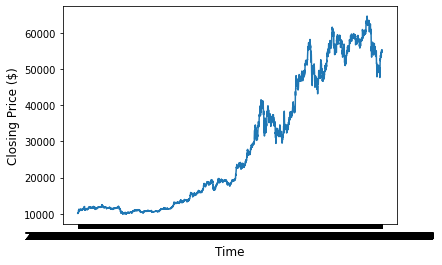

In [8]:
# train_df = train_df[1000:]
fig, ax = plt.subplots()
ax.set_ylabel('Closing Price ($)', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.plot(train['date_time'], train['price_close'])
plt.show()
